# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b1a5fca3482267ef614e9259d587bfa8f18206717f4ceda7dad242ad978f5c06
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=09d0c032520bf66e196069e8c3ab265cc0be318f11d4c977e2fd6419b476f49a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

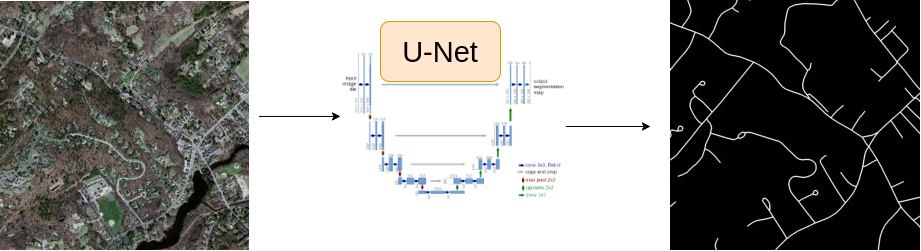

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 15.34 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 20

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255.0

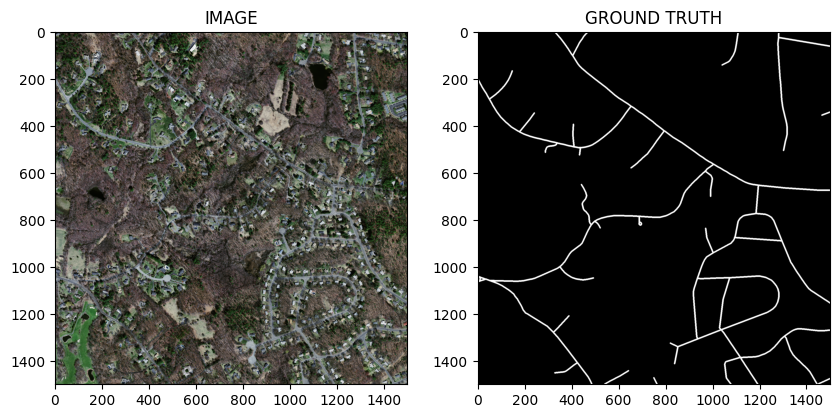

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.Tensor(mask)/255.0

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


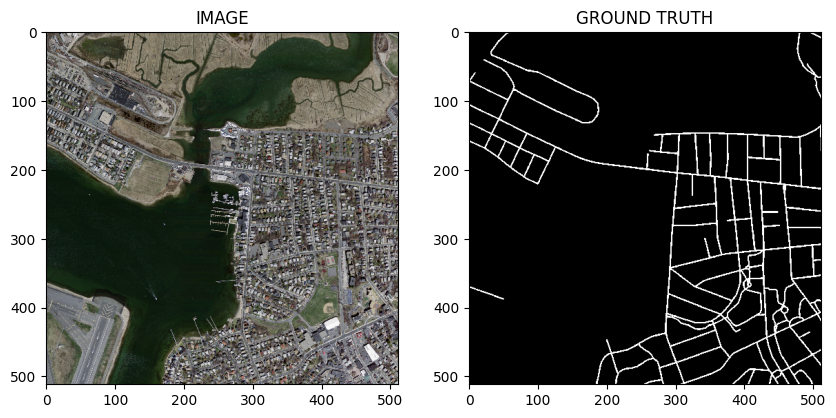

In [ ]:
idx = 3

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'Total no of batches in trainloader : {len(trainloader)}')
print(f'Total no of batches in validloader : {len(validloader)}')

Total no of batches in trainloader : 20
Total no of batches in validloader : 5


In [ ]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape : {masks.shape}')
  break;

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation = None
    )

  def forward(self, images, masks=None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode= 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    else:
      return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 328MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader, model, optimizer):

  model.train()

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model):

  model.eval()

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("Saved Model")
    best_loss = valid_loss

  print(f'Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')

100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Saved Model
Epoch : 1 Train Loss : 1.0309662908315658 Valid Loss : 1.0722012758255004


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Saved Model
Epoch : 2 Train Loss : 0.7741698890924453 Valid Loss : 0.8071823477745056


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Saved Model
Epoch : 3 Train Loss : 0.7322611719369888 Valid Loss : 0.7179784774780273


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Saved Model
Epoch : 4 Train Loss : 0.7060466408729553 Valid Loss : 0.6745439410209656


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Saved Model
Epoch : 5 Train Loss : 0.6728987574577332 Valid Loss : 0.651115894317627


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 6 Train Loss : 0.6558347105979919 Valid Loss : 0.7132146954536438


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Saved Model
Epoch : 7 Train Loss : 0.6611279010772705 Valid Loss : 0.6359693765640259


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Saved Model
Epoch : 8 Train Loss : 0.6499512940645218 Valid Loss : 0.6304976105690002


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 9 Train Loss : 0.6554058149456978 Valid Loss : 0.7077629089355468


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Saved Model
Epoch : 10 Train Loss : 0.6337493360042572 Valid Loss : 0.6130892693996429


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 11 Train Loss : 0.6305292248725891 Valid Loss : 0.658863878250122


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Saved Model
Epoch : 12 Train Loss : 0.632736274600029 Valid Loss : 0.6070664942264556


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch : 13 Train Loss : 0.6149965792894363 Valid Loss : 0.6353911757469177


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 14 Train Loss : 0.6060994416475296 Valid Loss : 0.6361914277076721


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch : 15 Train Loss : 0.6006299898028373 Valid Loss : 0.6459771752357483


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch : 16 Train Loss : 0.6060628086328507 Valid Loss : 0.6093896508216858


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Saved Model
Epoch : 17 Train Loss : 0.5949864566326142 Valid Loss : 0.580508691072464


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Saved Model
Epoch : 18 Train Loss : 0.5916761308908463 Valid Loss : 0.5673908412456512


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Saved Model
Epoch : 19 Train Loss : 0.5881942555308342 Valid Loss : 0.5603922724723815


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 20 Train Loss : 0.600167977809906 Valid Loss : 0.5941489636898041


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch : 21 Train Loss : 0.5992465674877167 Valid Loss : 0.6083256721496582


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Saved Model
Epoch : 22 Train Loss : 0.5861020296812057 Valid Loss : 0.5599651634693146


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch : 23 Train Loss : 0.5802040591835975 Valid Loss : 0.629284656047821


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch : 24 Train Loss : 0.5793181493878364 Valid Loss : 0.5972050607204438


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

Saved Model
Epoch : 25 Train Loss : 0.5787524804472923 Valid Loss : 0.5424275100231171


# Task 9 : Inference

In [ ]:
idx = 10

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

In [ ]:
pred_mask

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

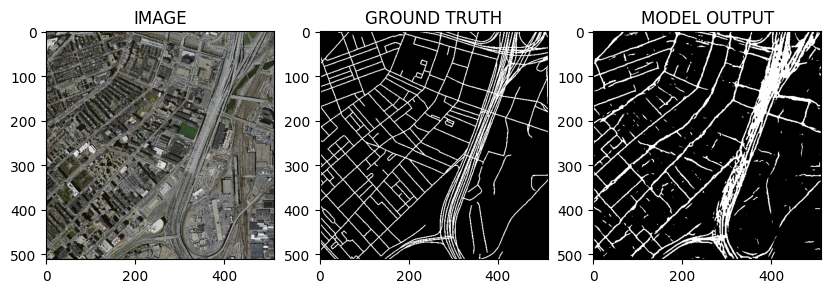

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))